In [3]:
import pandas as pd

def show_csv_head(csv_path, n_rows=24):
    """
    Display the first n rows of a CSV file.
    
    Args:
        csv_path (str): Path to the CSV file
        n_rows (int): Number of rows to display (default: 24)
        
    Returns:
        pd.DataFrame: DataFrame containing the first n rows
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"First {n_rows} rows of {csv_path}:")
        return df.head(n_rows)
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

# Example usage:
csv_head = show_csv_head("/home/jovyan/combined_mfcc_aus_shifted_sparse.csv")
print(csv_head)

First 24 rows of /home/jovyan/combined_mfcc_aus_shifted_sparse.csv:
                    video_file  frame_idx      mfcc_1     mfcc_2     mfcc_3  \
0   s10_anger_1_sequential.mp4          1  373.469787  43.022091   4.353659   
1   s10_anger_1_sequential.mp4          2  368.388319  47.992458  -0.670857   
2   s10_anger_1_sequential.mp4          3  352.405353  29.694968 -14.188416   
3   s10_anger_1_sequential.mp4          4  367.409847  50.474221  -7.641396   
4   s10_anger_1_sequential.mp4          5  353.027966  44.500309 -14.929805   
5   s10_anger_1_sequential.mp4          6  335.206089  50.726584  -4.417920   
6   s10_anger_1_sequential.mp4          7  340.177692  39.577079 -15.556436   
7   s10_anger_1_sequential.mp4          8  340.768554  46.194812 -13.163357   
8   s10_anger_1_sequential.mp4          9         NaN        NaN        NaN   
9   s10_anger_1_sequential.mp4         10         NaN        NaN        NaN   
10  s10_anger_1_sequential.mp4         11         NaN        Na

In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.
  Obtaining dependency information for numpy<2.3.0,>=2 from https://files.pythonhosted.org/packages/b4/63/3de6a34ad7ad6646ac7d2f55ebc6ad439dbbf9c4370017c50cf403fb19b5/numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy

In [ ]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Added missing import

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:  # Changed variable name to avoid conflict
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync  


train_uc_set = '/home/jovyan/enterface-dataset-new/output/train'
val_uc_set = '/home/jovyan/enterface-dataset-new/output/val'
test_uc_set = '/home/jovyan/enterface-dataset-new/output/test'

uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}

import pandas as pd
def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan//enterface-dataset-new/model"
pretrained_model = tf.saved_model.load(model_path)


class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Moved the model building code outside of the class definition
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    
    x = layers.Dense(512, activation='relu',  
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(len(uc_label2id),  
                        activation=None, 
                        dtype='float32')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="enhanced_model")
    
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,
            weight_decay=0.01  # Weight decay for additional regularization
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']  # Only tracking accuracy now
    )

model.summary()

history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=100,
)

2025-07-15 14:03:06.945303: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-15 14:03:08.804423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "enhanced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                    

2025-07-15 14:03:23.020689: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 749
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-07-15 14:03:34.065711: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e44c49ca70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-15 14:03:34.065772: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-15 14:03:34.831414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-15 14:03:39.538654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-15 14:04:11.300039: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_21__1', 8 bytes spill stores, 8 bytes spill loads

2025-07-15 14:04:13.567573: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line i

93/93 [==============================] - ETA: 0s - loss: 3.1135 - accuracy: 0.2446

2025-07-15 14:05:10.557801: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 248
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

93/93 [==============================] - 138s 943ms/step - loss: 3.1135 - accuracy: 0.2446 - val_loss: 2.2868 - val_accuracy: 0.3306
Epoch 2/100
93/93 [==============================] - 84s 855ms/step - loss: 2.6746 - accuracy: 0.2849 - val_loss: 2.2733 - val_accuracy: 0.3266
Epoch 3/100
93/93 [==============================] - 80s 850ms/step - loss: 2.4946 - accuracy: 0.2890 - val_loss: 2.2948 - val_accuracy: 0.3508
Epoch 4/100
93/93 [==============================] - 81s 862ms/step - loss: 2.3407 - accuracy: 0.3495 - val_loss: 2.0557 - val_accuracy: 0.3992
Epoch 5/100
93/93 [==============================] - 82s 873ms/step - loss: 2.2887 - accuracy: 0.3522 - val_loss: 2.0876 - val_accuracy: 0.4073
Epoch 6/100
93/93 [==============================] - 79s 845ms/step - loss: 2.2242 - accuracy: 0.3723 - val_loss: 2.0157 - val_accuracy: 0.4315
Epoch 7/100
93/93 [==============================] - 79s 832ms/step - loss: 2.1469 - accuracy: 0.3952 - val_loss: 2.3183 - val_accuracy: 0.3427
Epo

In [2]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Added missing import

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:  # Changed variable name to avoid conflict
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  

input_size = 224
num_frame = 16
batch_size = 16 * strategy.num_replicas_in_sync  


train_uc_set = '/home/jovyan/enterface-dataset-new/output/train'
val_uc_set = '/home/jovyan/enterface-dataset-new/output/val'
test_uc_set = '/home/jovyan/enterface-dataset-new/output/test'

uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}

import pandas as pd
def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan//enterface-dataset-new/model"
pretrained_model = tf.saved_model.load(model_path)


class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Moved the model building code outside of the class definition
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    
    x = layers.Dense(512, activation='relu',  
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(len(uc_label2id),  
                        activation=None, 
                        dtype='float32')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="enhanced_model")
    
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,
            weight_decay=0.01  # Weight decay for additional regularization
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']  # Only tracking accuracy now
    )

model.summary()

history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=100,
)

2025-07-15 15:43:31.019729: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-15 15:43:32.802161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "enhanced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                    

2025-07-15 15:43:46.534877: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 749
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-07-15 15:43:57.564856: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7950025600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-15 15:43:57.564922: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-15 15:43:58.640842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-15 15:44:04.030456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-15 15:44:48.405370: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_21__1', 8 bytes spill stores, 8 bytes spill loads

2025-07-15 15:44:50.528883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line i

46/46 [==============================] - ETA: 0s - loss: 3.0423 - accuracy: 0.2391

2025-07-15 15:45:46.153449: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 248
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

46/46 [==============================] - 153s 2s/step - loss: 3.0423 - accuracy: 0.2391 - val_loss: 2.3869 - val_accuracy: 0.2542
Epoch 2/100
46/46 [==============================] - 89s 2s/step - loss: 2.5723 - accuracy: 0.3274 - val_loss: 2.5220 - val_accuracy: 0.2958
Epoch 3/100
46/46 [==============================] - 87s 2s/step - loss: 2.3632 - accuracy: 0.3533 - val_loss: 2.3863 - val_accuracy: 0.2792
Epoch 4/100
46/46 [==============================] - 85s 2s/step - loss: 2.3519 - accuracy: 0.3832 - val_loss: 2.3195 - val_accuracy: 0.3542
Epoch 5/100
46/46 [==============================] - 84s 2s/step - loss: 2.2384 - accuracy: 0.4022 - val_loss: 2.3862 - val_accuracy: 0.3708
Epoch 6/100
46/46 [==============================] - 82s 2s/step - loss: 2.1960 - accuracy: 0.4076 - val_loss: 2.4212 - val_accuracy: 0.3542
Epoch 7/100
46/46 [==============================] - 82s 2s/step - loss: 2.1331 - accuracy: 0.4253 - val_loss: 2.2873 - val_accuracy: 0.3667
Epoch 8/100
46/46 [=====

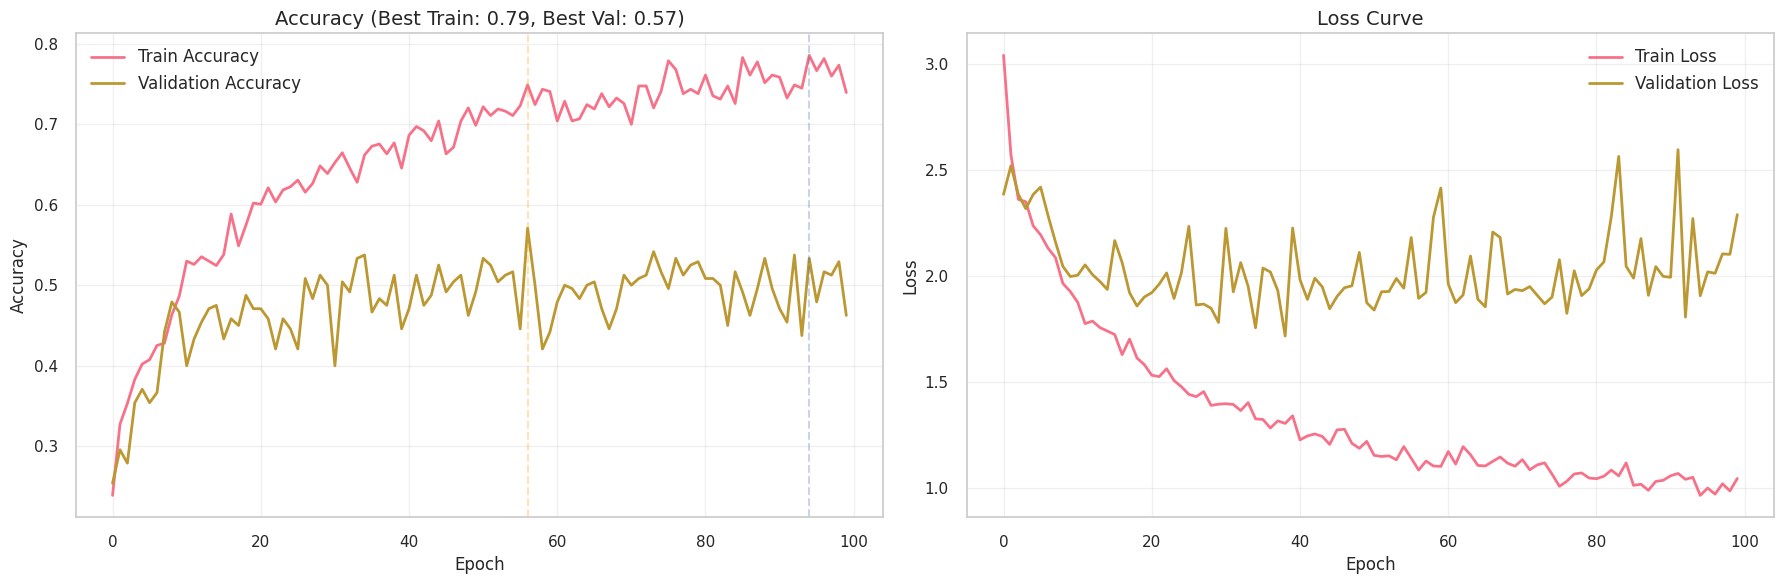


=== Key Performance Metrics ===
Highest Training Accuracy: 0.7853 at epoch 95
Highest Validation Accuracy: 0.5708 at epoch 57

Final Training Accuracy: 0.7391
Final Validation Accuracy: 0.4625

=== Test Set Evaluation ===


2025-07-15 18:05:52.113622: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 260
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

16/16 [==============================] - 23s 1s/step - loss: 2.4399 - accuracy: 0.4258
Test Accuracy: 0.4258

=== Confusion Matrix (Validation Set) ===


2025-07-15 18:06:14.840327: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 248
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

15/15 [==============================] - 26s 990ms/step


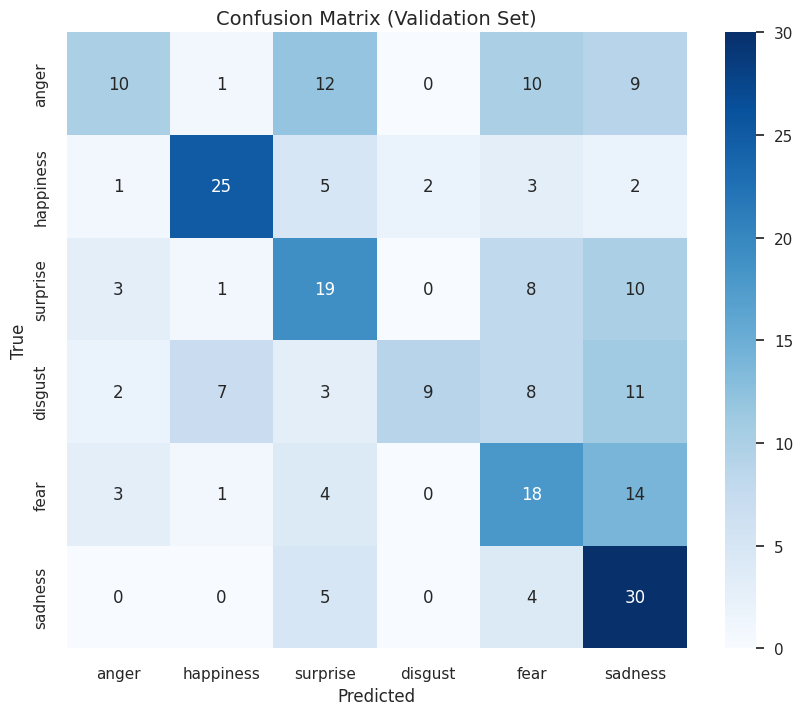


=== Classification Report (Validation Set) ===
              precision    recall  f1-score   support

       anger       0.53      0.24      0.33        42
   happiness       0.71      0.66      0.68        38
    surprise       0.40      0.46      0.43        41
     disgust       0.82      0.23      0.35        40
        fear       0.35      0.45      0.40        40
     sadness       0.39      0.77      0.52        39

    accuracy                           0.46       240
   macro avg       0.53      0.47      0.45       240
weighted avg       0.53      0.46      0.45       240



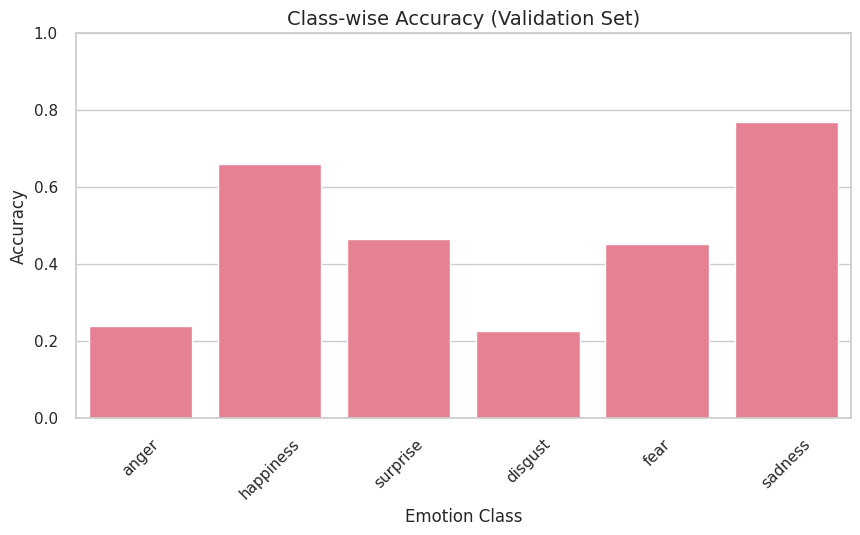

,Best Train Accuracy,Best Val Accuracy,Final Train Accuracy,Final Val Accuracy,Test Accuracy
0,0.785326,0.570833,0.739130,0.462500,0.425781


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn-v0_8')  # Updated style name
sns.set_theme(style="whitegrid")  # Updated seaborn theme
sns.set_palette("husl")

# 1. Plot training and validation accuracy/loss
plt.figure(figsize=(18, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

# Mark best epochs
best_train_epoch = np.argmax(history.history['accuracy'])
best_val_epoch = np.argmax(history.history['val_accuracy'])

plt.axvline(x=best_train_epoch, color='b', linestyle='--', alpha=0.3)
plt.axvline(x=best_val_epoch, color='orange', linestyle='--', alpha=0.3)

plt.title(f'Accuracy (Best Train: {max(history.history["accuracy"]):.2f}, Best Val: {max(history.history["val_accuracy"]):.2f})', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss Curve', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Print key metrics
print("\n=== Key Performance Metrics ===")
print(f"Highest Training Accuracy: {max(history.history['accuracy']):.4f} at epoch {best_train_epoch + 1}")
print(f"Highest Validation Accuracy: {max(history.history['val_accuracy']):.4f} at epoch {best_val_epoch + 1}")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# 3. Evaluate on test set
print("\n=== Test Set Evaluation ===")
test_loss, test_acc = model.evaluate(test_uc_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# 4. Confusion Matrix (on validation set)
print("\n=== Confusion Matrix (Validation Set) ===")
val_preds = model.predict(val_uc_ds)
val_pred_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = np.concatenate([y for x, y in val_uc_ds], axis=0)

cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=uc_label2id.keys(), 
            yticklabels=uc_label2id.keys())
plt.title('Confusion Matrix (Validation Set)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

# 5. Classification Report
print("\n=== Classification Report (Validation Set) ===")
print(classification_report(val_true_classes, val_pred_classes, 
                           target_names=uc_label2id.keys()))

# 6. Class-wise Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(uc_label2id.keys()), y=class_accuracy)
plt.title('Class-wise Accuracy (Validation Set)', fontsize=14)
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# 7. Training Summary Table
summary_data = {
    'Best Train Accuracy': [max(history.history['accuracy'])],
    'Best Val Accuracy': [max(history.history['val_accuracy'])],
    'Final Train Accuracy': [history.history['accuracy'][-1]],
    'Final Val Accuracy': [history.history['val_accuracy'][-1]],
    'Test Accuracy': [test_acc]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df.style.background_gradient(cmap='Blues').set_caption("Model Performance Summary"))